# Getting started

In this notebook, we use `TorchSurv` to train a model that predicts relative risk of breast cancer recurrence. We use a public data set, the [German Breast Cancer Study Group 2 (GBSG2)](https://paperswithcode.com/dataset/gbsg2). After training the model, we evaluate the predictive performance using evaluation metrics implemented in `TorchSurv`.


We first load the dataset using the package [lifelines](https://lifelines.readthedocs.io/en/latest/). The GBSG2 dataset contains features and recurrence free survival time (in days) for 686 women undergoing hormonal treatment. 

### Dependencies

To run this notebook, dependencies must be installed. the recommended method is to use our developpment conda environment (**preffered**). Instruction can be found [here](https://opensource.nibr.com/torchsurv/devnotes.html#set-up-a-development-environment-via-conda) to install all optional dependancies. The other method is to install only required packages using the command line below:

In [1]:
# Install only required packages (optional)
# %pip install lifelines
# %pip install matplotlib
# %pip install sklearn
# %pip install pandas

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import lifelines
import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Our package
from torchsurv.loss.cox import neg_partial_log_likelihood
from torchsurv.loss.weibull import neg_log_likelihood, log_hazard, survival_function
from torchsurv.metrics.brier_score import BrierScore
from torchsurv.metrics.cindex import ConcordanceIndex
from torchsurv.metrics.auc import Auc
from torchsurv.stats.kaplan_meier import KaplanMeierEstimator

# PyTorch boilerplate - see https://github.com/Novartis/torchsurv/blob/main/docs/notebooks/helpers_introduction.py
from helpers_introduction import Custom_dataset, plot_losses

In [ ]:
%env TORCH_LOGS=error
%env TORCHDYNAMO_VERBOSE=1

import torch._dynamo
torch._dynamo.config.suppress_errors = True

env: TORCH_LOGS=+dynamo
env: TORCHDYNAMO_VERBOSE=1


In [5]:
# Constant parameters accross models
# Detect available accelerator; Downgrade batch size if only CPU available
if any([torch.cuda.is_available(), torch.backends.mps.is_available()]):
    print("CUDA-enabled GPU/TPU is available.")
    BATCH_SIZE = 128  # batch size for training
else:
    print("No CUDA-enabled GPU found, using CPU.")
    BATCH_SIZE = 32  # batch size for training

EPOCHS = 100
LEARNING_RATE = 1e-2

CUDA-enabled GPU/TPU is available.


## Dataset overview

In [6]:
# Load GBSG2 dataset
df = lifelines.datasets.load_gbsg2()
df.head(5)

,horTh,age,menostat,tsize,tgrade,pnodes,progrec,estrec,time,cens
0,no,70,Post,21,II,3,48,66,1814,1
1,yes,56,Post,12,II,7,61,77,2018,1
2,yes,58,Post,35,II,9,52,271,712,1
3,yes,59,Post,17,II,4,60,29,1807,1
4,no,73,Post,35,II,1,26,65,772,1


The dataset contains the categorical features: 

- `horTh`: hormonal therapy, a factor at two levels (yes and no).
- `age`:  age of the patients in years.
- `menostat`: menopausal status, a factor at two levels pre (premenopausal) and post (postmenopausal).
- `tsize`: tumor size (in mm).
- `tgrade`: tumor grade, a ordered factor at levels I < II < III.
- `pnodes`: number of positive nodes.
- `progrec`: progesterone receptor (in fmol).
- `estrec`: estrogen receptor (in fmol).

Additionally, it contains our survival targets:

- `time`: recurrence free survival time (in days).
- `cens`: censoring indicator (0- censored, 1- event).

One common approach is to use a [one hot encoder](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) to convert them into numerical features. We then seperate the dataframes into features `X` and labels `y`. The following code also partitions the labels and features into training and testing cohorts.

## Data preparation

In [7]:
df_onehot = pd.get_dummies(df, columns=["horTh", "menostat", "tgrade"]).astype("float")
df_onehot.drop(
    ["horTh_no", "menostat_Post", "tgrade_I"],
    axis=1,
    inplace=True,
)
df_onehot.head(5)

,age,tsize,pnodes,progrec,estrec,time,cens,horTh_yes,menostat_Pre,tgrade_II,tgrade_III
0,70.0,21.0,3.0,48.0,66.0,1814.0,1.0,0.0,0.0,1.0,0.0
1,56.0,12.0,7.0,61.0,77.0,2018.0,1.0,1.0,0.0,1.0,0.0
2,58.0,35.0,9.0,52.0,271.0,712.0,1.0,1.0,0.0,1.0,0.0
3,59.0,17.0,4.0,60.0,29.0,1807.0,1.0,1.0,0.0,1.0,0.0
4,73.0,35.0,1.0,26.0,65.0,772.0,1.0,0.0,0.0,1.0,0.0


In [8]:
df_train, df_test = train_test_split(df_onehot, test_size=0.3)
df_train, df_val = train_test_split(df_train, test_size=0.3)
print(
    f"(Sample size) Training:{len(df_train)} | Validation:{len(df_val)} |Testing:{len(df_test)}"
)

(Sample size) Training:336 | Validation:144 |Testing:206


Let us setup the dataloaders for training, validation and testing.

In [9]:
# Dataloader
dataloader_train = DataLoader(
    Custom_dataset(df_train), batch_size=BATCH_SIZE, shuffle=True
)
dataloader_val = DataLoader(
    Custom_dataset(df_val), batch_size=len(df_val), shuffle=False
)
dataloader_test = DataLoader(
    Custom_dataset(df_test), batch_size=len(df_test), shuffle=False
)

In [10]:
# Sanity check
x, (event, time) = next(iter(dataloader_train))
num_features = x.size(1)

print(f"x (shape)    = {x.shape}")
print(f"num_features = {num_features}")
print(f"event        = {event.shape}")
print(f"time         = {time.shape}")

x (shape)    = torch.Size([128, 9])
num_features = 9
event        = torch.Size([128])
time         = torch.Size([128])


## Section 1: Cox proportional hazards model

In this section, we use the [Cox proportional hazards model](../_autosummary/torchsurv.loss.cox.html). Given covariate $x_{i}$, the hazard of patient $i$ has the form
$$
\lambda (t|x_{i}) =\lambda_{0}(t)\theta(x_{i})
$$
The baseline hazard $\lambda_{0}(t)$ is identical across subjects (i.e., has no dependency on $i$). The subject-specific risk of event occurrence is captured through the relative hazards $\{\theta(x_{i})\}_{i = 1, \dots, N}$.

We train a multi-layer perceptron (MLP) to model the subject-specific risk of event occurrence, i.e., the log relative hazards $\log\theta(x_{i})$. Patients with lower recurrence time are assumed to have higher risk of event. 

### Section 1.1: MLP model for log relative hazards

In [11]:
# Initiate Weibull model
cox_model = torch.nn.Sequential(
    torch.nn.BatchNorm1d(num_features),  # Batch normalization
    torch.nn.Linear(num_features, 32),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(32, 64),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(64, 1),  # Estimating log hazards for Cox models
)

# Compile model for faster performance
cox_model = torch.compile(cox_model)

### Section 1.2: MLP model training

In [12]:
torch.manual_seed(42)

# Init optimizer for Cox
optimizer = torch.optim.Adam(cox_model.parameters(), lr=LEARNING_RATE)

# Initiate empty list to store the loss on the train and validation sets
train_losses = []
val_losses = []

# training loop
for epoch in range(EPOCHS):
    epoch_loss = torch.tensor(0.0)
    for i, batch in enumerate(dataloader_train):
        x, (event, time) = batch
        optimizer.zero_grad()
        log_hz = cox_model(x)  # shape = (16, 1)
        loss = neg_partial_log_likelihood(log_hz, event, time, reduction="mean")
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach()

    if epoch % (EPOCHS // 10) == 0:
        print(f"Epoch: {epoch:03}, Training loss: {epoch_loss:0.2f}")

    # Reccord loss on train and test sets
    epoch_loss /= i + 1
    train_losses.append(epoch_loss)
    with torch.no_grad():
        x, (event, time) = next(iter(dataloader_val))
        val_losses.append(
            neg_partial_log_likelihood(cox_model(x), event, time, reduction="mean")
        )

[2025-03-14 13:53:39,716] torch._dynamo.convert_frame: [WARNING] WON'T CONVERT forward /Users/corolth1/anaconda3/envs/torchsurv/lib/python3.10/site-packages/torch/nn/modules/container.py line 213
[2025-03-14 13:53:39,716] torch._dynamo.convert_frame: [WARNING] ========== TorchDynamo Stack Trace ==========
[2025-03-14 13:53:39,716] torch._dynamo.convert_frame: [WARNING] Traceback (most recent call last):
[2025-03-14 13:53:39,716] torch._dynamo.convert_frame: [WARNING]   File "/Users/corolth1/anaconda3/envs/torchsurv/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 641, in _convert_frame
[2025-03-14 13:53:39,716] torch._dynamo.convert_frame: [WARNING]     result = inner_convert(frame, cache_size, hooks, frame_state)
[2025-03-14 13:53:39,716] torch._dynamo.convert_frame: [WARNING]   File "/Users/corolth1/anaconda3/envs/torchsurv/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 133, in _fn
[2025-03-14 13:53:39,716] torch._dynamo.convert_frame: [WARNING] 

Epoch: 000, Training loss: 12.63
Epoch: 010, Training loss: 12.19
Epoch: 020, Training loss: 11.99
Epoch: 030, Training loss: 11.99
Epoch: 040, Training loss: 11.70
Epoch: 050, Training loss: 11.84
Epoch: 060, Training loss: 11.67
Epoch: 070, Training loss: 11.70
Epoch: 080, Training loss: 11.46
Epoch: 090, Training loss: 11.39


We can visualize the training and validation losses.

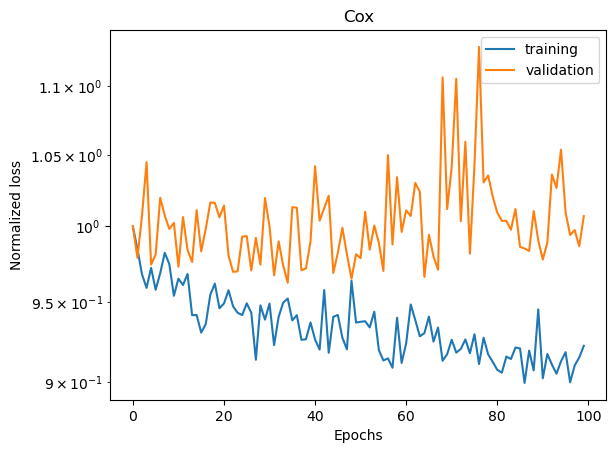

In [13]:
plot_losses(train_losses, val_losses, "Cox")

### Section 1.3: Cox proportional hazards model evaluation

We evaluate the predictive performance of the model using 

* the [concordance index](../_autosummary/torchsurv.metrics.cindex.html) (C-index), which measures the the probability that a model correctly predicts which of two comparable samples will experience an event first based on their estimated risk scores,
* the [Area Under the Receiver Operating Characteristic Curve](../_autosummary/torchsurv.metrics.auc.html) (AUC), which measures the probability that a model correctly predicts which of two comparable samples will experience an event by time t based on their estimated risk scores.

We cannot use the Brier score because this model is not able to estimate the survival function.

We start by evaluating the subject-specific relative hazards on the test set 

In [14]:
cox_model.eval()
with torch.no_grad():
    # test event and test time of length n
    x, (event, time) = next(iter(dataloader_test))
    log_hz = cox_model(x)  # log hazard of length n

We obtain the concordance index, and its confidence interval

In [15]:
# Concordance index
cox_cindex = ConcordanceIndex()
print("Cox model performance:")
print(f"Concordance-index   = {cox_cindex(log_hz, event, time)}")
print(f"Confidence interval = {cox_cindex.confidence_interval()}")

Cox model performance:
Concordance-index   = 0.6689541339874268
Confidence interval = tensor([0.5672, 0.7708])


We can also test whether the observed concordance index is greater than 0.5. The statistical test is specified with H0: c-index = 0.5 and Ha: c-index > 0.5. The p-value of the statistical test is

In [16]:
# H0: cindex = 0.5, Ha: cindex > 0.5
print("p-value = {}".format(cox_cindex.p_value(alternative="greater")))

p-value = 0.000571131706237793


For time-dependent prediction (e.g., 5-year mortality), the C-index is not a proper measure. Instead, it is recommended to use the AUC. The probability to correctly predicts which of two comparable patients will experience an event by 5-year based on their estimated risk scores is the AUC evaluated at 5-year (1825 days) obtained with

In [17]:
cox_auc = Auc()

new_time = torch.tensor(1825.0)

# auc evaluated at new time = 1825, 5 year
print(f"AUC 5-yr             = {cox_auc(log_hz, event, time, new_time=new_time)}")
print(f"AUC 5-yr (conf int.) = {cox_auc.confidence_interval()}")

AUC 5-yr             = tensor([0.7182])
AUC 5-yr (conf int.) = tensor([0.6577, 0.7786])


As before, we can test whether the observed Auc at 5-year is greater than 0.5. The statistical test is specified with H0: auc = 0.5 and Ha: auc > 0.5. The p-value of the statistical test is

In [18]:
print(f"AUC (p_value) = {cox_auc.p_value()}")

AUC (p_value) = tensor([0.])


## Section 2: Weibull accelerated failure time (AFT) model

In this section, we use the [Weibull accelerated failure (AFT) model](../_autosummary/torchsurv.loss.weibull.html). Given covariate $x_{i}$, the hazard of patient $i$ at time $t$ has the form
$$
\lambda (t|x_{i}) = \frac{\rho(x_{i}) } {\lambda(x_{i}) } + \left(\frac{t}{\lambda(x_{i})}\right)^{\rho(x_{i}) - 1}
$$

Given the hazard form, it can be shown that the event density follows a Weibull distribution parametrized by scale $\lambda(x_{i})$ and shape $\rho(x_{i})$. The subject-specific risk of event occurrence at time $t$ is captured through the hazards $\{\lambda (t|x_{i})\}_{i = 1, \dots, N}$. We train a multi-layer perceptron (MLP) to model the subject-specific log scale, $\log \lambda(x_{i})$, and the log shape, $\log\rho(x_{i})$. 

### Section 2.1: MLP model for log scale and log shape

In [19]:
# Same architecture than Cox model, beside outputs dimension
weibull_model = torch.nn.Sequential(
    torch.nn.BatchNorm1d(num_features),  # Batch normalization
    torch.nn.Linear(num_features, 32),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(32, 64),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(64, 2),  # Estimating log parameters for Weibull model
)

# Compile Weibull model
weibull_model = torch.compile(weibull_model)

### Section 2.2: MLP model training

In [20]:
torch.manual_seed(42)

# Init optimizer for Weibull
optimizer = torch.optim.Adam(weibull_model.parameters(), lr=LEARNING_RATE)

# Initialize empty list to store loss on train and validation sets
train_losses = []
val_losses = []

# training loop
for epoch in range(EPOCHS):
    epoch_loss = torch.tensor(0.0)
    for i, batch in enumerate(dataloader_train):
        x, (event, time) = batch
        optimizer.zero_grad()
        log_params = weibull_model(x)  # shape = (16, 2)
        loss = neg_log_likelihood(log_params, event, time, reduction="mean")
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach()

    if epoch % (EPOCHS // 10) == 0:
        print(f"Epoch: {epoch:03}, Training loss: {epoch_loss:0.2f}")

    # Reccord losses for the following figure
    train_losses.append(epoch_loss)
    with torch.no_grad():
        x, (event, time) = next(iter(dataloader_val))
        val_losses.append(
            neg_log_likelihood(weibull_model(x), event, time, reduction="mean")
        )

Epoch: 000, Training loss: 77743.04
Epoch: 010, Training loss: 20.16
Epoch: 020, Training loss: 19.04
Epoch: 030, Training loss: 18.72
Epoch: 040, Training loss: 18.25
Epoch: 050, Training loss: 18.60
Epoch: 060, Training loss: 18.44
Epoch: 070, Training loss: 17.88
Epoch: 080, Training loss: 17.66
Epoch: 090, Training loss: 17.50


We can visualize the training and validation losses.

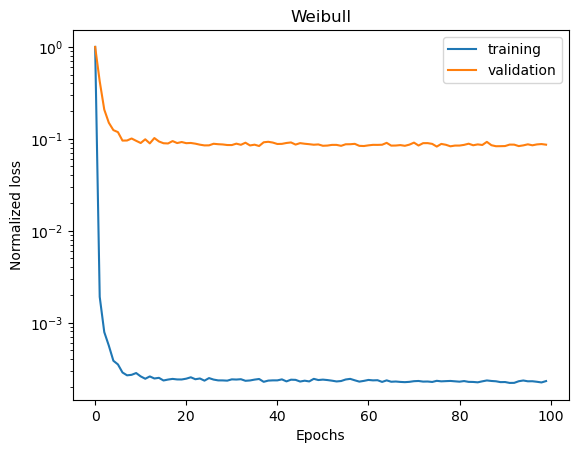

In [21]:
plot_losses(train_losses, val_losses, "Weibull")

### Section 2.3: Weibull AFT model evaluation

We evaluate the predictive performance of the model using 

* the [C-index](../_autosummary/torchsurv.metrics.cindex.html), which measures the the probability that a model correctly predicts which of two comparable samples will experience an event first based on their estimated risk scores,
* the [AUC](../_autosummary/torchsurv.metrics.auc.html), which measures the probability that a model correctly predicts which of two comparable samples will experience an event by time t based on their estimated risk scores, and
* the [Brier score](../_autosummary/torchsurv.metrics.brier_score.html), which measures the model's calibration by calculating the mean square error between the estimated survival function and the empirical (i.e., in-sample) event status.

We start by obtaining the subject-specific log hazard and survival probability at every time $t$ observed on the test set

In [22]:
weibull_model.eval()
with torch.no_grad():
    # event and time of length n
    x, (event, time) = next(iter(dataloader_test))
    log_params = weibull_model(x)  # shape = (n,2)

# Compute the log hazards from weibull log parameters
log_hz = log_hazard(log_params, time)  # shape = (n,n)

# Compute the survival probability from weibull log parameters
surv = survival_function(log_params, time)  # shape = (n,n)

We can evaluate the concordance index, its confidence interval and the p-value of the statistical test testing whether the c-index is greater than 0.5:

In [23]:
# Concordance index
weibull_cindex = ConcordanceIndex()
print("Weibull model performance:")
print(f"Concordance-index   = {weibull_cindex(log_hz, event, time)}")
print(f"Confidence interval = {weibull_cindex.confidence_interval()}")

# H0: cindex = 0.5, Ha: cindex >0.5
print(f"p-value             = {weibull_cindex.p_value(alternative = 'greater')}")

Weibull model performance:
Concordance-index   = 0.46184372901916504
Confidence interval = tensor([0.3347, 0.5889])
p-value             = 0.7218620181083679


For time-dependent prediction (e.g., 5-year mortality), the C-index is not a proper measure. Instead, it is recommended to use the AUC. The probability to correctly predicts which of two comparable patients will experience an event by 5-year based on their estimated risk scores is the AUC evaluated at 5-year (1825 days) obtained with

In [24]:
new_time = torch.tensor(1825.0)

# subject-specific log hazard at \5-yr
log_hz_t = log_hazard(log_params, time=new_time)  # shape = (n)
weibull_auc = Auc()

# auc evaluated at new time = 1825, 5 year
print(f"AUC 5-yr             = {weibull_auc(log_hz_t, event, time, new_time=new_time)}")
print(f"AUC 5-yr (conf int.) = {weibull_auc.confidence_interval()}")
print(f"AUC 5-yr (p value)   = {weibull_auc.p_value(alternative='greater')}")

AUC 5-yr             = tensor([0.4048])
AUC 5-yr (conf int.) = tensor([0.3559, 0.4537])
AUC 5-yr (p value)   = tensor([0.9999])


Lastly, we can evaluate the time-dependent Brier score and the integrated Brier score

In [25]:
brier_score = BrierScore()

# brier score at first 5 times
print(f"Brier score             = {brier_score(surv, event, time)[:5]}")
print(f"Brier score (conf int.) = {brier_score.confidence_interval()[:,:5]}")

# integrated brier score
print(f"Integrated Brier score  = {brier_score.integral()}")

Brier score             = tensor([0.4326, 0.4348, 0.4348, 0.4332, 0.4400])
Brier score (conf int.) = tensor([[0.4268, 0.4275, 0.4262, 0.4237, 0.4295],
        [0.4383, 0.4421, 0.4433, 0.4427, 0.4505]])
Integrated Brier score  = 0.24334388971328735


We can test whether the time-dependent Brier score is smaller than what would be expected if the survival model was not providing accurate predictions beyond random chance. We use a bootstrap permutation test and obtain the p-value with:

In [26]:
# H0: bs = bs0, Ha: bs < bs0; where bs0 is the expected brier score if the survival model was not providing accurate predictions beyond random chance.

# p-value for brier score at first 5 times
print(f"Brier score (p-val)        = {brier_score.p_value(alternative = 'less')[:5]}")

Brier score (p-val)        = tensor([0.5700, 0.3320, 0.3870, 0.2960, 0.3190])


## Section 3: Models comparison

We can compare the predictive performance of the Cox proportional hazards model against the Weibull AFT model.

### Section 3.1: Concordance index
The statistical test is formulated as follows, H0: cindex cox = cindex weibull, Ha: cindex cox > cindex weibull

In [27]:
print(f"Cox cindex     = {cox_cindex.cindex}")
print(f"Weibull cindex = {weibull_cindex.cindex}")
print("p-value        = {}".format(cox_cindex.compare(weibull_cindex)))

Cox cindex     = 0.6689541339874268
Weibull cindex = 0.46184372901916504
p-value        = 0.008401399478316307


### Section 3.2: AUC at 5-year

The statistical test is formulated as follows, H0: 5-yr auc cox = 5-yr auc weibull, Ha: 5-yr auc cox > 5-yr auc weibull

In [28]:
print(f"Cox 5-yr AUC     = {cox_auc.auc}")
print(f"Weibull 5-yr AUC = {weibull_auc.auc}")
print("p-value          = {}".format(cox_auc.compare(weibull_auc)))

Cox 5-yr AUC     = tensor([0.7182])
Weibull 5-yr AUC = tensor([0.4048])
p-value          = tensor([7.1643e-13])


## Section 4: Kaplan Meier


In [29]:
# Create a Kaplan-Meier estimator
km = KaplanMeierEstimator()

# Use our observed testing dataset
event = torch.tensor(df_test["cens"].values).bool()
time = torch.tensor(df_test["time"].values)

# Compute the estimator
km(event, time)

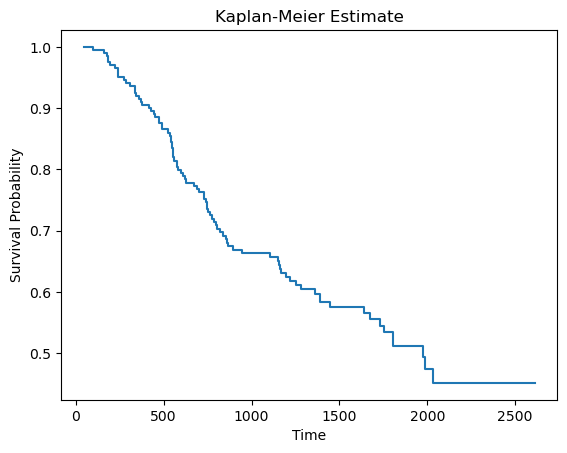

In [30]:
# plot estimate
km.plot_km()

In [31]:
# Print the survival values at each time step
km.print_survival_table()

Time	Survival
----------------
46.00	1.0000
57.00	1.0000
63.00	1.0000
65.00	1.0000
98.00	0.9950
160.00	0.9901
177.00	0.9851
181.00	0.9802
184.00	0.9752
195.00	0.9703
213.00	0.9703
223.00	0.9653
238.00	0.9603
241.00	0.9554
242.00	0.9504
272.00	0.9454
288.00	0.9404
308.00	0.9355
322.00	0.9355
338.00	0.9255
344.00	0.9205
358.00	0.9155
369.00	0.9105
374.00	0.9055
417.00	0.9004
426.00	0.8954
446.00	0.8904
448.00	0.8854
461.00	0.8854
471.00	0.8804
475.00	0.8754
490.00	0.8703
491.00	0.8653
525.00	0.8603
526.00	0.8603
529.00	0.8603
537.00	0.8552
542.00	0.8501
544.00	0.8450
548.00	0.8348
550.00	0.8297
552.00	0.8247
554.00	0.8196
559.00	0.8145
567.00	0.8145
573.00	0.8093
577.00	0.8042
579.00	0.7991
598.00	0.7940
612.00	0.7889
615.00	0.7889
622.00	0.7837
624.00	0.7785
651.00	0.7785
663.00	0.7785
670.00	0.7733
687.00	0.7681
692.00	0.7681
698.00	0.7628
723.00	0.7628
730.00	0.7575
731.00	0.7522
737.00	0.7522
740.00	0.7522
742.00	0.7469
747.00	0.7415
748.00	0.7361
753.00	0.7361
754.00	0.7307
762.00	0